In [104]:
import numpy as np
from scipy.optimize import nnls
from scipy.io import loadmat
import matplotlib.pyplot as plt


data_path = '/Users/dellacc/Library/CloudStorage/OneDrive-TheFrancisCrickInstitute/cajal comp neuroscience 2024/Project - Palmigiano/Data_cell_types_small_size.mat'
data = loadmat(data_path)


def phi(x, a =1, k = 2):
    return a * x**k

def phi_inv(y, a = 1, k = 2):
    return (y/a)**(1/k)

In [105]:
E = data['pyr']
PV = data['pv']
SOM = data['sst']
VIP = data['vip']
I = data['contrast']

# means
E_mean = np.mean(E, axis = 0)
PV_mean = np.mean(PV, axis = 0)
SOM_mean = np.mean(SOM, axis = 0)
VIP_mean = np.mean(VIP, axis = 0)

#matrix A has rows with rates of the four cells across the 6 conditions
A = np.concatenate((E_mean[:,np.newaxis], -PV_mean[:,np.newaxis], -SOM_mean[:,np.newaxis], -VIP_mean[:,np.newaxis], I[0,:][:,np.newaxis]), axis = 1)
ones = np.ones_like(I)
A = np.concatenate((A, ones[0,:][:,np.newaxis]), axis = 1)
print(A.shape)

phi_inv_E = phi_inv(E_mean)
#solve nnls Ax = y
x_E = nnls(A, phi_inv_E)[0]
phi_inv_PV = phi_inv(PV_mean)
x_PV = nnls(A, phi_inv_PV)[0]

phi_inv_SOM = phi_inv(SOM_mean)
Anc = A.copy()
Anc[:,-2] = 0
x_SOM = nnls(Anc, phi_inv_SOM)[0]

phi_inv_VIP = phi_inv(VIP_mean)
x_VIP = nnls(Anc, phi_inv_VIP)[0]

weight_matrix = np.concatenate((x_E, x_PV, x_SOM, x_VIP))
weight_matrix = weight_matrix.reshape(4,6)

mean_weights = weight_matrix


(6, 6)


In [3]:
import torch

In [106]:
import sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference import SNPE, simulate_for_sbi

## a few tries and ocde that doesn't work

In [107]:

def exp_prior(theta, k = 1):
    #need to return a torch tensor
    return k*torch.exp(-k*theta)


In [108]:
print(torch.distributions.Exponential(torch.tensor([E_mean])).batch_shape)

torch.Size([1, 6])


/var/folders/nw/5r29xbqs6jx_h23mjxw6ykm8qhq097/T/ipykernel_77903/1935400652.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  print(torch.distributions.Exponential(torch.tensor([E_mean])).batch_shape)


In [407]:
#create 6 priors that have mean as mean of the population
ones = np.ones(24)
exp_d = [torch.distributions.Exponential(torch.tensor([0.5], dtype = torch.float32))] *24
# exp_d = sbi.utils.MultipleIndependent(exp_d)
prior, num_parameters, prior_returns_numpy = process_prior(exp_d)


/Users/dellacc/anaconda3/envs/sbi-env-2/lib/python3.11/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 24 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


In [8]:
print(prior.batch_shape)

torch.Size([])


In [121]:
print(I.shape)

(1, 6)


In [374]:
#initialise the rates
#sample from exponential distribution
params = np.random.exponential(0.5, 24)
params = torch.tensor([params], dtype = torch.float32)
print(params.shape)
rates_0 = torch.rand(4)
# rates_0 = torch.tensor(np.random.rand(4), dtype = torch.float32)
print(rates_0.shape)
contrast = I_norm[0,0]
contrast = torch.tensor([I_norm[0,0]])
tau = torch.tensor(1)
delta_t = torch.tensor(0.01)
# print(vec_1.shape)
error = 1
threshold = torch.tensor(1e-7)
i = 0
while error > threshold:
    vec_1 = torch.tensor([rates_0[0], -rates_0[1], -rates_0[2], -rates_0[3], I_norm[0,0], 1], dtype = torch.float32)
    vec_2 = torch.tensor([rates_0[0], -rates_0[1], -rates_0[2], -rates_0[3], 0,1], dtype = torch.float32)
    delta_r = (-rates_0 + phi(torch.tensor([vec_1 @params[0,0:6], vec_1@params[0,6:12],vec_2@ params[0,12:18], vec_2@params[0,18:]]))) / tau * delta_t
    error = torch.norm(delta_r)
    rates_0 = rates_0 + delta_r
    i +=1
    # print(rates_0.shape)
    # rates_vec = torch.concatenate([rates_0, torch.tensor([contrast], dtype = torch.float32), torch.tensor([1], dtype = torch.float32)])
rates_0 = torch.reshape(rates_0, (1,4))
print(i)


torch.Size([1, 24])
torch.Size([4])
1143


In [375]:
print(rates_0)

tensor([[0.0005, 0.0010, 0.0452, 0.0014]])


In [388]:
I_norm = I/100
def simulator(params):
    #initialise the rates
    rates_0 = torch.rand(4)
    # rates_0 = torch.tensor(np.random.rand(4), dtype = torch.float32)
    # print(rates_0.shape)
    contrast = I_norm[0,1]
    contrast = torch.tensor([I_norm[0,0]])
    tau = torch.tensor(1)
    delta_t = torch.tensor(0.01)
    # print(vec_1.shape)
    error = 1
    threshold = torch.tensor(1e-7)
    i = 0
    max_iter = 2000
    while (error > threshold) & (i < max_iter):
        vec_1 = torch.tensor([rates_0[0], -rates_0[1], -rates_0[2], -rates_0[3], 1, I_norm[0,0]], dtype = torch.float32)
        vec_2 = torch.tensor([rates_0[0], -rates_0[1], -rates_0[2], -rates_0[3], 1, 0], dtype = torch.float32)
    
        delta_r = (-rates_0 + phi(torch.tensor([vec_1 @params[0,0:6], vec_1@params[0,6:12],vec_2@ params[0,12:18], vec_2@params[0,18:]]))) / tau * delta_t
        error = torch.norm(delta_r)
        rates_0 = rates_0 + delta_r
        i += 1
        # print(rates_0.shape)
        # rates_vec = torch.concatenate([rates_0, torch.tensor([contrast], dtype = torch.float32), torch.tensor([1], dtype = torch.float32)])
    rates_0 = torch.reshape(rates_0, (1,4))
    return rates_0

simulator_process = process_simulator(simulator, prior, prior_returns_numpy)    

In [410]:
lower_bounds = torch.zeros(24)
upper_bounds = torch.ones(24)
prior_one = sbi.utils.BoxUniform(low=lower_bounds, high=upper_bounds)


In [417]:
print(prior_one.shape)

AttributeError: 'BoxUniform' object has no attribute 'shape'

In [438]:
def single_simulation(
    W: torch.tensor,
    h: torch.tensor,
    dt: float = 0.05,
    eps_threshold: float = 1e-8,
    max_iters: int = 5000,
    check_assumptions=True,
):
    n_types = 4

    rate_scale_in = 3.0
    rs = rate_scale_in * torch.rand(n_types)

    eps = 1.0
    k = 1
    while eps > eps_threshold:
        delta_rs = dt * (-rs + func(torch.matmul(W, rs) + h))
        rs = rs + delta_rs
        eps = torch.sum(torch.pow(delta_rs, 2))
        k += 1
        if eps > 10 or k == max_iters:
            rs = torch.full_like(rs, torch.tensor(float("inf")))
            break

    if check_assumptions:
        ISN = W[0, 0] > 1 / (2 * h[0] + 2 * torch.matmul(W, rs)[0])
        # $w_{EE} > 1/ [ f' (h_E + \sum_b W_{Eb} R_b ) ] $
        P_paradoxical = (
            torch.inverse(
                torch.inverse(torch.diag(2 * h + 2 * torch.matmul(W, rs))) - W
            )[1, 1]
            < 0
        )
        # P-neurons have negative response to input
        # if ~P_paradoxical:
        if ~ISN or ~P_paradoxical:
            rs = torch.full_like(rs, torch.tensor(float("inf")))

    return rs


def simulator_p(
    pars,
    contrasts=torch.tensor([0, 0.0600, 0.1200, 0.2500, 0.5000, 1]),
    all_positive=True,
):

    """""
    input has the form of a 1d array structured as follows: 
        - the first 4 elements are the first column of the synaptic matrix 
        - the following 12 elements are the other 3 columns. 
        - the following 4 elements are the input baseline vector 
        - the final 4 elements are the four coefficients describing linear dependence on contrast
        
    """ ""

    n_contrasts = 6
    n_types = 4

    if all_positive:
        signs = torch.tensor(
            [
                1,
                1,
                1,
                1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                1,
                1,
                1,
                1,
                1,
                1,
                # 1,
                # 1,
            ]
        )
        pars = pars * signs
    print(pars.shape)
    pars_w = pars[: n_types * n_types]
    print('weights shape',pars_w.shape)
    W = torch.reshape(pars_w, (n_types, n_types)).swapaxes(0, 1)
    hb = pars[-2 * n_types : -n_types]
    hc = pars[-n_types:]

    rates = torch.zeros((n_contrasts, n_types))

    for contrast_ind, contrast in enumerate(contrasts):
        rates[contrast_ind, :] = single_simulation(W, hb + hc * contrast)

    return rates


def simulator_agos(
    pars,
    contrasts=torch.tensor([0, 0.0600, 0.1200, 0.2500, 0.5000, 1]),
    all_positive=True,
):

    """""
    input has the form of a 1d array structured as follows: 
        - the first 4 elements are the first column of the synaptic matrix 
        - the following 12 elements are the other 3 columns. 
        - the following 4 elements are the input baseline vector 
        - the final 2 elements are the four coefficients describing linear dependence on contrast
        
    """ ""

    n_contrasts = 6
    n_types = 4

    if all_positive:
        signs = torch.tensor(
            [
                1,
                1,
                1,
                1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                1,
                1,
                1,
                1,
                1,
                1,
            ]
        )
        pars = pars * signs

    W = torch.reshape(pars[: n_types * n_types], (n_types, n_types)).swapaxes(0, 1)
    hb = pars[-n_types - 2 : -2]
    hc = torch.cat((pars[-2:], torch.tensor([0, 0])), dim=0)

    rates = torch.zeros((n_contrasts, n_types))

    for contrast_ind, contrast in enumerate(contrasts):
        rates[contrast_ind, :] = single_simulation(W, hb + hc * contrast)

    return rates



In [439]:
import sbi.inference
W = (
    torch.tensor(
        [
            [1.0295, 0.6362, 1.2731, 0.2379],
            [0.9789, 0.3061, 0.7670, 0.1853],
            [0.9766, 0.0567, 0.0006, 0.6039],
            [2.2591, 1.5424, 0.2300, 0.0008],
        ]
    )
    .transpose(0, 1)
    .flatten()
)
hb = torch.tensor([0.6073, 0.4761, 0.4012, 0.5539])
# hc = torch.tensor([0.8252, 0.5346, 0.0, 0.0])
# use restricted parameter space:
hc = torch.tensor([0.8252, 0.5346])
true_params = torch.cat((W, hb, hc), 0).expand(1, 22)
print(f"True parameters: {true_params}")
FRAC = 0.99
assert FRAC < 1 and FRAC > 0
upper_bounds = torch.squeeze(true_params + FRAC * torch.abs(true_params))
lower_bounds = torch.squeeze(true_params - FRAC * torch.abs(true_params))
prior_one = sbi.utils.BoxUniform(low=lower_bounds, high=upper_bounds)


simulator_sbi, prior_sbi = sbi.inference.prepare_for_sbi(simulator_p, prior_one)

check_sbi_inputs(simulator_p, prior_one)

True parameters: tensor([[1.0295e+00, 9.7890e-01, 9.7660e-01, 2.2591e+00, 6.3620e-01, 3.0610e-01,
         5.6700e-02, 1.5424e+00, 1.2731e+00, 7.6700e-01, 6.0000e-04, 2.3000e-01,
         2.3790e-01, 1.8530e-01, 6.0390e-01, 8.0000e-04, 6.0730e-01, 4.7610e-01,
         4.0120e-01, 5.5390e-01, 8.2520e-01, 5.3460e-01]])
torch.Size([2, 22])
weights shape torch.Size([2, 22])
torch.Size([22])
weights shape torch.Size([16])
torch.Size([1, 22])
weights shape torch.Size([1, 22])


RuntimeError: shape '[4, 4]' is invalid for input of size 22

In [378]:
inference = SNPE(prior)

In [379]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=5000)

Running 5000 simulations.: 100%|██████████| 5000/5000 [00:50<00:00, 98.34it/s] 


In [247]:
print(x[0:10])

tensor([[1.2522e+00, 1.2399e+01, 4.5035e+00, 3.0046e-01],
        [3.9791e+00, 3.9268e-01, 2.0859e+00, 2.2571e+00],
        [4.8914e+00, 5.5043e-02, 1.4680e+00, 1.1454e-01],
        [1.2303e+00, 2.3006e+00, 2.1710e+00, 8.2783e-02],
        [1.0014e-01, 2.2738e-02, 6.5151e+00, 2.1066e+00],
        [1.5961e+00, 6.1344e-02, 7.6573e-01, 1.1028e+00],
        [1.7360e-01, 1.8920e-01, 6.8174e-04, 9.8469e-01],
        [7.3734e-02, 3.7754e+00, 5.9622e-01, 1.2142e+01],
        [1.0066e+00, 7.8599e-01, 8.6320e-05, 1.7237e+01],
        [1.3150e-02, 1.6322e+00, 2.7580e-01, 2.5020e+00]])


In [380]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train(force_first_round_loss=True)


 Neural network successfully converged after 90 epochs.

In [94]:

inference_i = inference_i.append_simulations(theta_i, x_i)
density_estimator_i = inference_i.train()

 Neural network successfully converged after 223 epochs.

In [381]:
posterior = inference.build_posterior(density_estimator)
print(posterior) # prints how the posterior was trained


Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [250]:
from sbi.analysis import pairplot


In [252]:
print(E_mean.shape)
print()

(6,)


In [382]:
x_obs = torch.tensor([E_mean[0], PV_mean[0], SOM_mean[0], VIP_mean[0]])
samples = posterior.sample((10000,), x=x_obs)


Drawing 10000 posterior samples: 10053it [00:38, 261.37it/s]                          


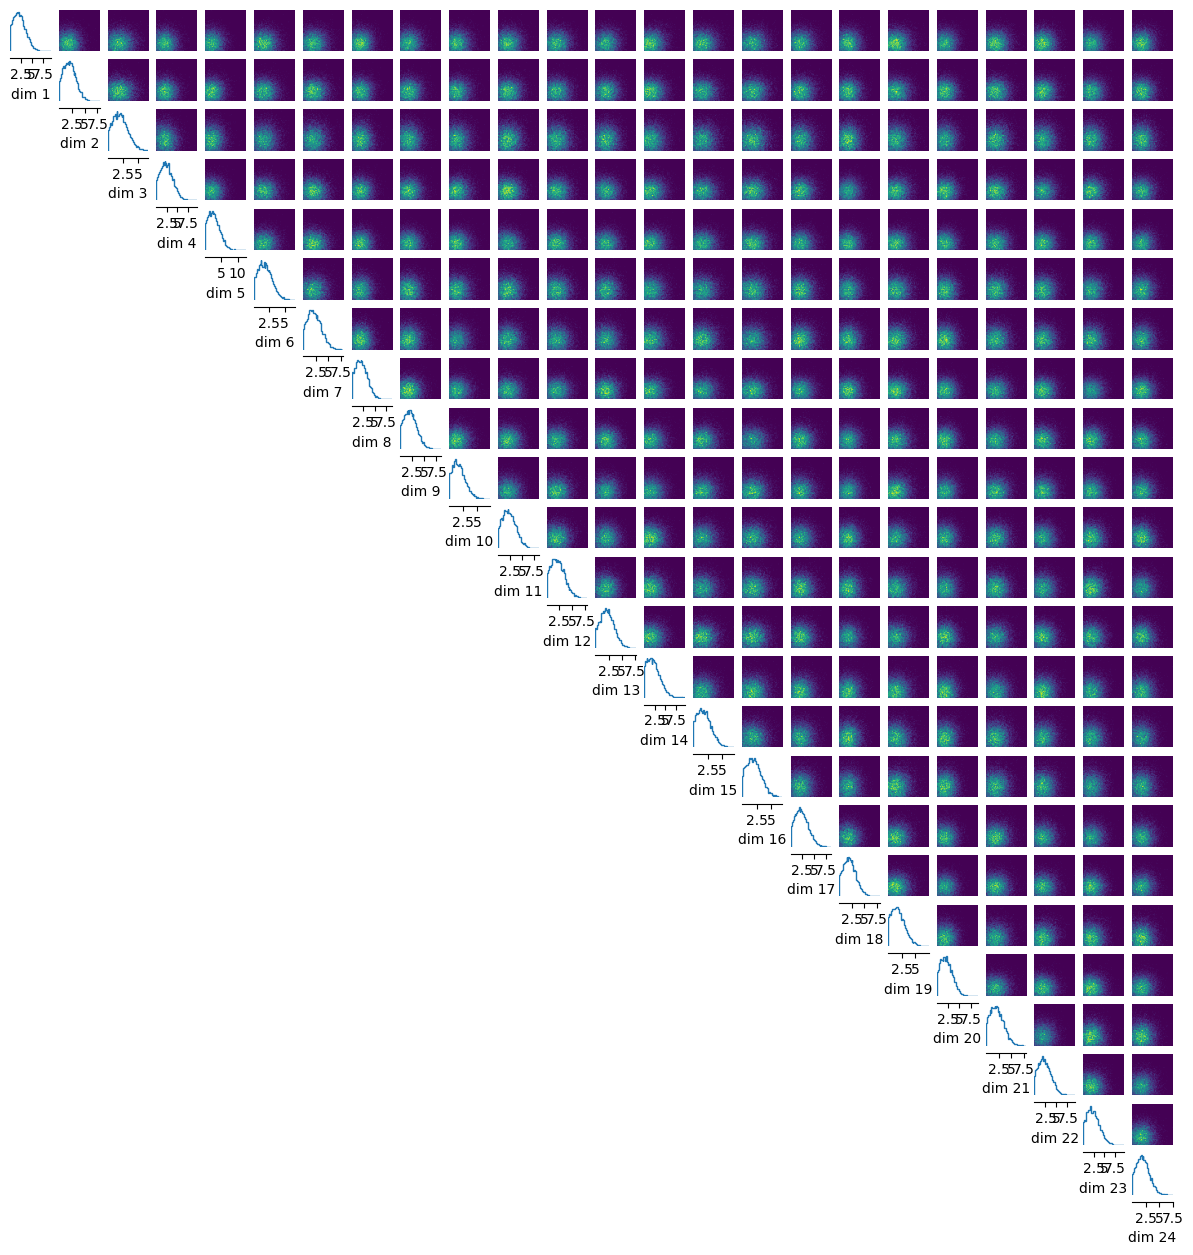

In [383]:

_ = pairplot(samples, figsize=(15, 15))

torch.Size([10000, 24])
(24,)
[1.20940650e+00 1.37282264e+00 5.19498169e-01 1.82100689e+00
 7.91215803e-04 3.00287771e+00 1.44488370e+00 1.62068486e+00
 8.43991220e-01 2.22230697e+00 1.83236992e+00 2.34274030e+00
 1.03599250e+00 6.71473682e-01 3.34240675e+00 1.53111207e+00
 2.06370592e+00 1.56132567e+00 2.13328436e-01 2.35418510e+00
 3.18822122e+00 2.76895666e+00 1.21912467e+00 2.31399012e+00]


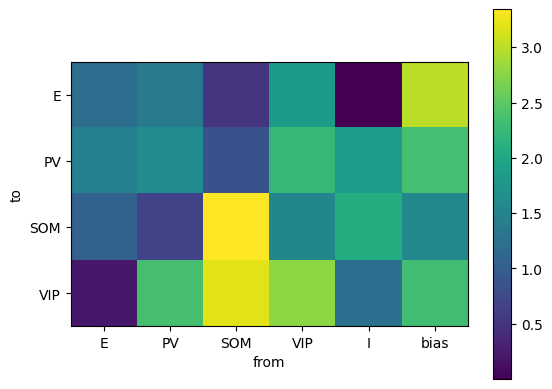

In [384]:
print(samples.shape)
from scipy.stats import mode

weights_E = mode(samples.numpy())[0]
print(weights_E.shape)
print(weights_E)

weights = weights_E.reshape(4,6)
plt.imshow(weights)
plt.xticks(np.arange(6), ['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])
plt.yticks(np.arange(4), ['E', 'PV', 'SOM', 'VIP'])
plt.xlabel('from')
plt.ylabel('to')
plt.colorbar()
plt.show()


Drawing 10000 posterior samples: 10837it [00:00, 42938.38it/s]                          


[2.04878470e-05 1.86466910e-02 7.58823395e-01 3.10497910e-01
 6.52769923e-01 2.42745191e-01]


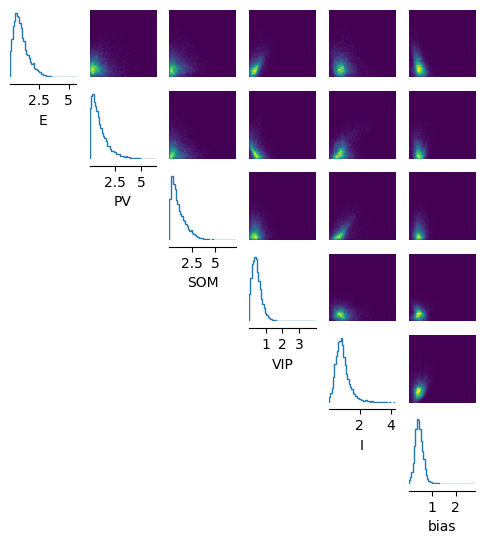

In [98]:
x_obs = PV_mean
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, figsize=(6, 6),labels=['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])

weights_PV = mode(samples.numpy())[0]
print(weights_PV)

Drawing 10000 posterior samples: 11682it [00:00, 34284.18it/s]                          


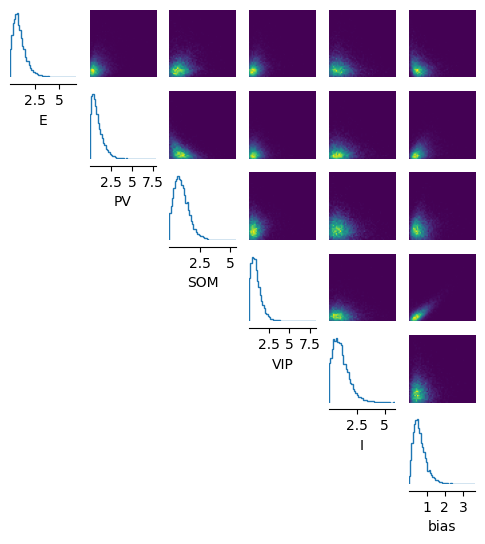

In [99]:
x_obs = SOM_mean
samples = posterior_i.sample((10000,), x=x_obs)
_ = pairplot(samples, figsize=(6, 6),labels=['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])

weights_SOM = mode(samples.numpy())[0]


Drawing 10000 posterior samples: 11713it [00:00, 37159.23it/s]                          


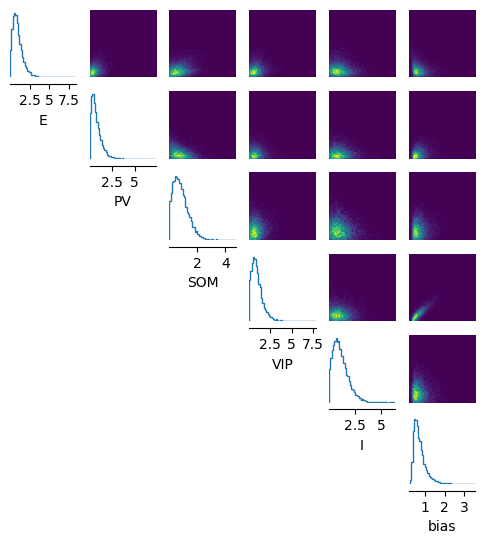

In [100]:
x_obs = VIP_mean
samples = posterior_i.sample((10000,), x=x_obs)
_ = pairplot(samples, figsize=(6, 6),labels=['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])

weights_VIP = mode(samples.numpy())[0]  


In [101]:
print(weights_E)
print(weights_PV)
print(weights_SOM)
print(weights_VIP)

[0.13461049 0.2722283  1.97305417 0.20677374 0.56083685 0.42732432]
[2.04878470e-05 1.86466910e-02 7.58823395e-01 3.10497910e-01
 6.52769923e-01 2.42745191e-01]
[0.72278565 0.34829825 0.50796831 0.73163044 0.34609377 0.45558614]
[0.51067078 0.04902187 0.2327953  0.58566946 0.4047136  0.41335556]


In [102]:
weights = np.concatenate((weights_E, weights_PV, weights_SOM, weights_VIP))
print(weights.shape)
weights = weights.reshape(4,6)

(24,)


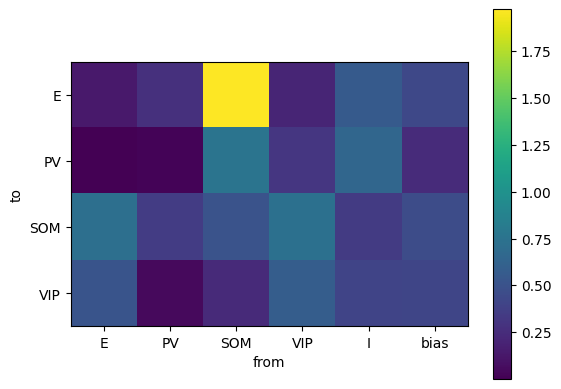

In [103]:
plt.imshow(weights)
plt.colorbar()
plt.xticks(np.arange(6), ['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])
plt.yticks(np.arange(4), ['E', 'PV', 'SOM', 'VIP'])
plt.xlabel('from')
plt.ylabel('to')
plt.show()

## use different priors

In [73]:
#create 6 priors that have mean as mean of the population

exp_d_e = [torch.distributions.Exponential(torch.tensor([1/mean_weights[0,i]])) for i in range(len(ones))]
exp_d_e = sbi.utils.MultipleIndependent(exp_d_e)
prior_e, num_parameters, prior_returns_numpy = process_prior(exp_d_e)

exp_d_pv = [torch.distributions.Exponential(torch.tensor([1/mean_weights[1,i]])) for i in range(len(ones))]
exp_d_pv = sbi.utils.MultipleIndependent(exp_d_pv)
prior_pv, num_parameters, prior_returns_numpy = process_prior(exp_d_pv)

exp_d_som = [torch.distributions.Exponential(torch.tensor([1/mean_weights[2,i]])) for i in range(len(ones))]
exp_d_som = sbi.utils.MultipleIndependent(exp_d_som)
prior_som, num_parameters, prior_returns_numpy = process_prior(exp_d_som)

exp_d_vip = [torch.distributions.Exponential(torch.tensor([1/mean_weights[3,i]])) for i in range(len(ones))]
exp_d_vip = sbi.utils.MultipleIndependent(exp_d_vip)
prior_vip, num_parameters, prior_returns_numpy = process_prior(exp_d_vip)

check_sbi_inputs(simulator_E, prior_e)
check_sbi_inputs(simulator_E, prior_pv)
check_sbi_inputs(simulator_SOM, prior_som)
check_sbi_inputs(simulator_SOM, prior_vip)


/var/folders/nw/5r29xbqs6jx_h23mjxw6ykm8qhq097/T/ipykernel_77903/3593042996.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  exp_d_e = [torch.distributions.Exponential(torch.tensor([1/mean_weights[0,i]])) for i in range(len(ones))]
/var/folders/nw/5r29xbqs6jx_h23mjxw6ykm8qhq097/T/ipykernel_77903/3593042996.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  exp_d_pv = [torch.distributions.Exponential(torch.tensor([1/mean_weights[1,i]])) for i in range(len(ones))]
/var/folders/nw/5r29xbqs6jx_h23mjxw6ykm8qhq097/T/ipykernel_77903/3593042996.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  exp_d_som = [torch.distributions.Exponential(torch.tensor([1/mean_weights[2,i]])) for i in range(len(ones))]
/var/folders/nw/5r29xbqs6jx_h23mjxw6ykm8qhq097/T/ipykernel_77903/3593042996.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  exp_d_vip = [torch.distributions.Exponential(torch.tensor([1/mean_weights[3,i]])) for i in range(l

In [74]:
theta_e, x_e = simulate_for_sbi(simulator_E, proposal=prior_e, num_simulations=2000)
theta_pv, x_pv = simulate_for_sbi(simulator_E, proposal=prior_pv, num_simulations=2000)
theta_som, x_som = simulate_for_sbi(simulator_SOM, proposal=prior_som, num_simulations=2000)
theta_vip, x_vip = simulate_for_sbi(simulator_SOM, proposal=prior_vip, num_simulations=2000)

Running 2000 simulations.: 100%|██████████| 2000/2000 [00:00<00:00, 21932.49it/s]


In [75]:
inference_e = SNPE(prior_e)
inference_pv = SNPE(prior_pv)
inference_som = SNPE(prior_som)
inference_vip = SNPE(prior_vip)

In [76]:
inference_e = inference_e.append_simulations(theta_e, x_e)
density_estimator_e = inference_e.train()

inference_pv = inference_pv.append_simulations(theta_pv, x_pv)
density_estimator_pv = inference_pv.train()

inference_som = inference_som.append_simulations(theta_som, x_som)
density_estimator_som = inference_som.train()

inference_vip = inference_vip.append_simulations(theta_vip, x_vip)
density_estimator_vip = inference_vip.train()


 Neural network successfully converged after 162 epochs.

In [77]:
posterior_e = inference_e.build_posterior(density_estimator_e)
posterior_pv = inference_pv.build_posterior(density_estimator_pv)
posterior_som = inference_som.build_posterior(density_estimator_som)
posterior_vip = inference_vip.build_posterior(density_estimator_vip)
print(posterior) # prints how the posterior was trained
print(posterior_i) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


Drawing 10000 posterior samples: 10528it [00:00, 16027.53it/s]                          


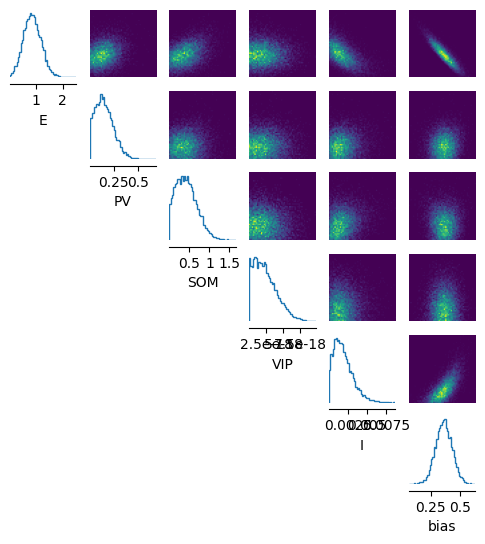

In [79]:
x_obs = E_mean
samples = posterior_e.sample((10000,), x=x_obs)
_ = pairplot(samples, figsize=(6, 6),labels=['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])

weights_E = mode(samples.numpy())[0]


Drawing 10000 posterior samples: 10502it [00:01, 7959.09it/s]                          


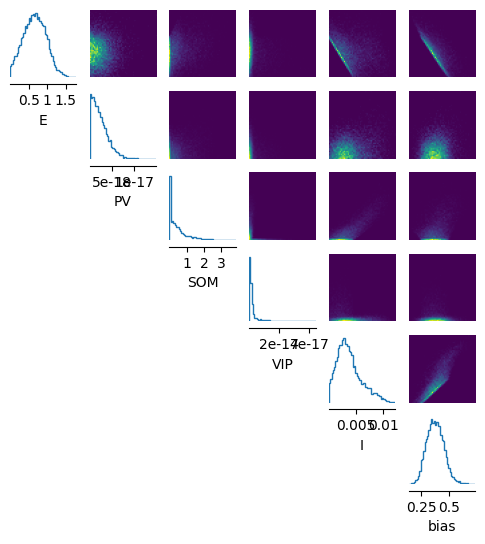

In [80]:
x_obs = PV_mean
samples = posterior_pv.sample((10000,), x=x_obs)
_ = pairplot(samples, figsize=(6, 6),labels=['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])

weights_PV = mode(samples.numpy())[0]

Drawing 10000 posterior samples: 10031it [00:01, 5093.40it/s]                          


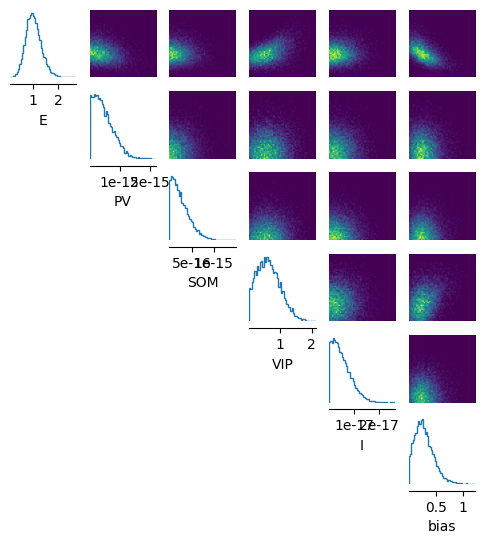

In [81]:
x_obs = SOM_mean
samples = posterior_som.sample((10000,), x=x_obs)
_ = pairplot(samples, figsize=(6, 6),labels=['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])

weights_SOM = mode(samples.numpy())[0]

Drawing 10000 posterior samples: 10230it [00:02, 5030.43it/s]                          


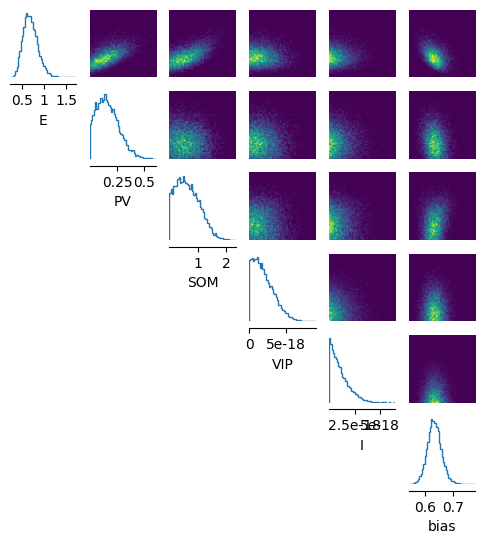

In [82]:
x_obs = VIP_mean
samples = posterior_vip.sample((10000,), x=x_obs)
_ = pairplot(samples, figsize=(6, 6),labels=['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])

weights_VIP = mode(samples.numpy())[0]

(24,)


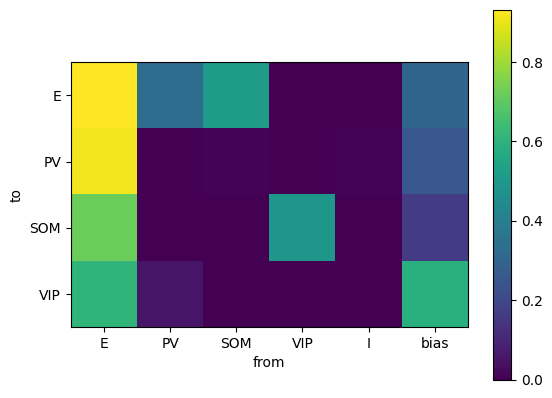

In [83]:
weights = np.concatenate((weights_E, weights_PV, weights_SOM, weights_VIP))
print(weights.shape)
weights = weights.reshape(4,6)

plt.imshow(weights)
plt.colorbar()
plt.xticks(np.arange(6), ['E', 'PV', 'SOM', 'VIP', 'I', 'bias'])
plt.yticks(np.arange(4), ['E', 'PV', 'SOM', 'VIP'])
plt.xlabel('from')
plt.ylabel('to')
plt.show()

## using Linda's version

In [441]:
#test simulator
i=0
max_it = 3000
wb = torch.rand((24))
#r =torch.rand(4) 
#I = data['contrast'][0][0]
#A_1 =torch.tensor([r[0], -1* r[1], r[2], -1*r[3], I, 1])
#A_2 = torch.tensor([r[0], -1* r[1], r[2], -1*r[3], 1, 1])
delta_t = 0.05


r = torch.rand(4, 6)  # Initialize r with shape (4, 6)
I_values = data['contrast'][0][:6] /torch.tensor([100]) # Get the 6 different I values

while i < max_it:
    
    for j, I in enumerate(I_values):
        A_1 = torch.tensor([r[0, j], -1 * r[1, j], -1 *r[2, j], -1 * r[3, j], I, 1])
        A_2 = torch.tensor([r[0, j], -1 * r[1, j], -1* r[2, j], -1 * r[3, j], 0, 1])
        
        r_delta = -r[:, j] + phi(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
        r[:, j] = r[:, j] + delta_t * r_delta
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-4 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

tensor([[6.9857e-01, 7.8671e-01,        nan, 1.0715e+00,        nan, 1.8946e+00],
        [3.3669e-01, 3.8191e-01,        nan, 5.2224e-01,        nan, 7.1401e-01],
        [6.0123e-03, 1.3373e-02,        nan, 6.4710e-02,        nan, 6.6509e-01],
        [5.4241e-02, 5.0198e-02,        nan, 3.5416e-02,        nan, 1.0878e-03]]) 495


In [444]:
def simulator(wb):
    # Define inputs
    i = 0
    max_it = 3000
    
    delta_t = 0.05
    r = torch.rand(24)  # Initialize r with shape (4, 6)
    I_values = data['contrast'][0][:6]/torch.tensor([100])  # Get the 6 different I values

    while i < max_it:
        
        for j, I in enumerate(I_values):
            A_1 = torch.tensor([r[j*4], -1 * r[j*4 +1], -1 *r[j*4 +2], -1 * r[j*4+3], I, 1])
            A_2 = torch.tensor([r[j*4], -1 * r[j*4+1], -1* r[j*4+2], -1 * r[j*4+3], 0, 1])
            
            r_delta = -r[j*4:j*4 +4] + phi(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
            r[j*4:j*4+4] = r[j*4:j*4+4] + delta_t * r_delta
        
        eps = torch.sum(torch.pow(r_delta, 2))
        if eps < 1e-4 or torch.isnan(eps):
            break
        
        i += 1
    
    return r

In [445]:
prior = [torch.distributions.Exponential(torch.tensor([4.0]))]*24
prior, num_parameters, prior_returns_numpy = process_prior(prior)

/Users/dellacc/anaconda3/envs/sbi-env-2/lib/python3.11/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 24 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


In [446]:
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [447]:
check_sbi_inputs(simulator, prior)

In [448]:
inference = SNPE(prior = prior)


In [449]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)


Running 10000 simulations.: 100%|██████████| 10000/10000 [17:00<00:00,  9.80it/s] 


In [450]:
inference = inference.append_simulations(theta, x)

In [451]:
from sbi import analysis as analysis
x_o = []
for i in range(6):
    x_o = x_o + [E_mean[i], PV_mean[i], SOM_mean[i], VIP_mean[i]]
x_o = torch.tensor(x_o).squeeze()

posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(12, 12)
)

AssertionError: Observed data shape (torch.Size([1, 24])) must match the shape of simulated data x (torch.Size([1, 4])).